In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Assignment 2: NLP

## Envirnment Setup

Importing the dataset (needs to be done only once per notebook)

In [2]:
# needs to be run only once per notebook
# !wget "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
# !tar -xzf aclImdb_v1.tar.gz

In [3]:
!cat aclImdb/imdb.vocab | wc -l # number of vocab words

89526


## Imports

In [2]:
import nltk # natural language tool kit: for text pre-processing
import os # for listing directories
from bs4 import BeautifulSoup as bs # library for removing html tags from text
import numpy as np # no comment :P
from nltk.corpus import stopwords # a set of common stopwords from nltk
from gensim import models
import gensim
from collections import namedtuple
from helpers import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
%load_ext autoreload
%autoreload 2

In [5]:
# download resources for nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/abdelrahman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/abdelrahman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/abdelrahman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/abdelrahman/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '``', "''", '...','the','for',"'s","'m"])

## Reading the dataset and preprocessing the text

In [7]:
train_pos = []
train_neg = []
train_unsup = []

wnl = nltk.WordNetLemmatizer()

In [8]:
train_pos = read_data('aclImdb/train/pos')
print("read {} positive training reviews".format(len(train_pos)))

train_neg = read_data('aclImdb/train/neg')
print("read {} negative training reviews".format(len(train_neg)))

train_unsup = read_data('aclImdb/train/unsup')
print("read {} unsupervised training reviews".format(len(train_unsup)))

train_data = train_pos + train_neg + train_unsup
print(len(train_data))

read 12500 positive training reviews
read 12500 negative training reviews
read 50000 unsupervised training reviews
75000


In [9]:
test_pos = read_data('aclImdb/test/pos')
print("read {} positive test reviews".format(len(test_pos)))

test_neg = read_data('aclImdb/test/neg')
print("read {} negative test reviews".format(len(test_neg)))

test_data = test_pos + test_neg
print(len(test_data))

read 12500 positive test reviews
read 12500 negative test reviews
25000


In [19]:
train_labels = np.array([1]*12500 + [0]*12500)
test_labels = np.array([1]*12500 + [0]*12500)

In [10]:
flag = 0
pos_model = None
neg_model = None
if os.path.isfile('gensim_pos_model') and os.path.isfile('gensim_neg_model') and os.path.isfile('gensim_unsup_model'):
    flag = 1
    pos_model = gensim.models.doc2vec.Doc2Vec.load('gensim_pos_model')
    print('Postive Model loaded')
    neg_model = gensim.models.doc2vec.Doc2Vec.load('gensim_neg_model')
    print('Negative Model Loaded')
    unsup_model = gensim.models.doc2vec.Doc2Vec.load('gensim_unsup_model')
    print('unsup Model Loaded')

In [11]:
if flag == 0:
    analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')

    reviews_pos = [analyzedDocument(review, [i]) for i,review in zip(range(0, 12500), train_pos)]
    reviews_neg = [analyzedDocument(review, [i]) for i,review in zip(range(12500, 25000), train_neg)]
    reviews_unsup = [analyzedDocument(review, [i]) for i,review in zip(range(25000, 75000), train_unsup)]

    reviews = reviews_pos + reviews_neg + reviews_unsup
    print(len(reviews))

75000


In [12]:
if flag == 0:
    pos_model = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=10, workers=4)
    neg_model = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=10, workers=4)
    unsup_model = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=10, workers=4)
    pos_model.build_vocab(reviews)
    neg_model.build_vocab(reviews)
    unsup_model.build_vocab(reviews)

In [13]:
if flag == 0:
    for epoch in range(5):
        
        pos_model.train(reviews, total_examples=pos_model.corpus_count, epochs=pos_model.epochs)
        pos_model.alpha -= 0.002  # decrease the learning rate
        pos_model.min_alpha = pos_model.alpha  # fix the learning rate, no decay
        
        neg_model.train(reviews, total_examples=neg_model.corpus_count, epochs=neg_model.epochs)
        neg_model.alpha -= 0.002  # decrease the learning rate
        neg_model.min_alpha = neg_model.alpha  # fix the learning rate, no decay
        
        unsup_model.train(reviews, total_examples=neg_model.corpus_count, epochs=neg_model.epochs)
        unsup_model.alpha -= 0.002  # decrease the learning rate
        unsup_model.min_alpha = unsup_model.alpha  # fix the learning rate, no decay

In [14]:
if flag == 0:
    pos_model.save('gensim_pos_model')
    print('Save Postive Mdel')
    neg_model.save('gensim_neg_model')
    print('save Negative Model')
    neg_model.save('gensim_unsup_model')
    print('save unsup Model')

Save Postive Mdel
save Negative Model
save unsup Model


In [15]:
test_reviews = np.empty([25000, 900])

for idx, review in enumerate(test_data):
#     inferred_vector = pos_model.infer_vector(review)
    inferred_vector = np.concatenate((pos_model.infer_vector(review), neg_model.infer_vector(review), unsup_model.infer_vector(review)), axis=0)
    test_reviews[idx] = inferred_vector

print(test_reviews.shape)

(25000, 900)


In [16]:

train_pos_vec = []
train_neg_vec = []
train_unsup_vec = []

for x in range(0, 12500):
#     train_pos_vec.append(pos_model.docvecs[x])
    train_pos_vec.append(np.concatenate((pos_model.docvecs[x], neg_model.docvecs[x], unsup_model.docvecs[x]), axis=0))

for x in range(12500, 25000):
#     train_neg_vec.append(pos_model.docvecs[x])
    train_neg_vec.append(np.concatenate((pos_model.docvecs[x], neg_model.docvecs[x],  unsup_model.docvecs[x]), axis=0))
        


## Classification with logistic regression

In [17]:
logistic_params = {'C': [0.1, 0.5, 1, 5, 10]}
random_forest_params = {'n_estimators': [10,50,100,300]}
ada_params = {'n_estimators': [10, 50, 100], 'base_estimator':[LogisticRegression(C=5)]}
knn_params = {'n_neighbors': [5, 11, 17]}

lr_clfs = get_clfs_for_combinations(LogisticRegression, logistic_params)
rf_clfs = get_clfs_for_combinations(RandomForestClassifier, random_forest_params)
ada_clfs = get_clfs_for_combinations(AdaBoostClassifier, ada_params)
knn_clfs = get_clfs_for_combinations(KNeighborsClassifier, knn_params)

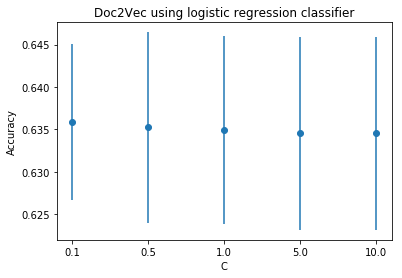

In [21]:
scores_dict = cross_validate(np.concatenate((train_pos_vec, train_neg_vec), axis=0), train_labels, lr_clfs)
param = 'C'
accuracies_dict = clf_to_accuracies_dict(scores_dict, param)
fig = plot_accuracies(accuracies_dict, xlabel=param, title='Doc2Vec using logistic regression classifier')
fig.savefig('plots/Doc2Vec-lr')

In [18]:
from sklearn.svm import SVC

rbf_clf = SVC(kernel='rbf', C = 1)
rbf_clf.fit(np.concatenate((train_pos_vec, train_neg_vec), axis=0), [1]*12500 + [0]*12500)
rbf_clf.score(test_reviews, [1]*12500 + [0]*12500)

In [19]:
rbf_clf = SVC(kernel='rbf', C = 0.1) # better at C=0.1
rbf_clf.fit(np.concatenate((train_pos_vec, train_neg_vec), axis=0), [1]*12500 + [0]*12500)
rbf_clf.score(test_reviews, [1]*12500 + [0]*12500)

0.82520000000000004

In [20]:
from sklearn.ensemble import RandomForestClassifier
RF_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
RF_clf.fit(np.concatenate((train_pos_vec, train_neg_vec), axis=0), [1]*12500 + [0]*12500)
RF_clf.score(test_reviews, [1]*12500 + [0]*12500)

0.79803999999999997

In [21]:
from sklearn.ensemble import AdaBoostClassifier
ADA_clf = AdaBoostClassifier(n_estimators = 100)
ADA_clf.fit(np.concatenate((train_pos_vec, train_neg_vec), axis=0), [1]*12500 + [0]*12500)
ADA_clf.score(test_reviews, [1]*12500 + [0]*12500)

0.73943999999999999

In [22]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(np.concatenate((train_pos_vec, train_neg_vec), axis=0), [1]*12500 + [0]*12500)
gnb.score(test_reviews, [1]*12500 + [0]*12500)

0.59172000000000002

In [23]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf = clf.fit(np.concatenate((train_pos_vec, train_neg_vec), axis=0), [1]*12500 + [0]*12500)
clf.score(test_reviews, [1]*12500 + [0]*12500)

0.56320000000000003